In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import os, sys
from os.path import abspath

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import warnings
warnings.filterwarnings('ignore')
import keras.backend as k
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Activation, Dropout
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
tf.compat.v1.disable_eager_execution()
tf.get_logger().setLevel('ERROR')

from art.estimators.classification import KerasClassifier
from art.attacks.poisoning import PoisoningAttackBackdoor, PoisoningAttackCleanLabelBackdoor
from art.attacks.poisoning.perturbations import add_pattern_bd
from art.utils import load_mnist, preprocess, to_categorical
from art.defences.trainer import AdversarialTrainerMadryPGD


from art.estimators.classification.deep_partition_ensemble import DeepPartitionEnsemble

# Load the Data

In [2]:
(x_raw, y_raw), (x_raw_test, y_raw_test), min_, max_ = load_mnist(raw=True)

# Random Selection:
n_train = np.shape(x_raw)[0]
num_selection = 10000
random_selection_indices = np.random.choice(n_train, num_selection)
x_raw = x_raw[random_selection_indices]
y_raw = y_raw[random_selection_indices]

# Poison training data
percent_poison = .33
x_train, y_train = preprocess(x_raw, y_raw)
x_train = np.expand_dims(x_train, axis=3)

x_test, y_test = preprocess(x_raw_test, y_raw_test)
x_test = np.expand_dims(x_test, axis=3)

# Shuffle training data
n_train = np.shape(y_train)[0]
shuffled_indices = np.arange(n_train)
np.random.shuffle(shuffled_indices)
x_train = x_train[shuffled_indices]
y_train = y_train[shuffled_indices]

# Initialize the Model Architecture

In [3]:
# Create Keras convolutional neural network - basic architecture from Keras examples
# Source here: https://github.com/keras-team/keras/blob/master/examples/mnist_cnn.py
def create_model():    
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=x_train.shape[1:]))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(10, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# Set up the Model Backdoor

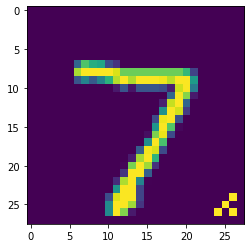

In [4]:
backdoor = PoisoningAttackBackdoor(add_pattern_bd)
example_target = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1])
pdata, plabels = backdoor.poison(x_test, y=example_target)

plt.imshow(pdata[0].squeeze())

# Create the poison data
For this example, we will select 9 as the target class. Thus, the adversary's goal is to poison the model so adding a trigger will result in the trained model misclassifying the triggered input as a 9.

First, the adversary will create a proxy classifier (i.e., a classifier that is similar to the target classifier). As the clean label attack generates noise using PGD in order to encourage the trained classifier to rely on the trigger, it is important that the generated noise be transferable. Thus, adversarial training is used.

In [5]:
# Poison some percentage of all non-nines to nines
targets = to_categorical([9], 10)[0] 

proxy = AdversarialTrainerMadryPGD(KerasClassifier(create_model()), nb_epochs=10, eps=0.15, eps_step=0.001)
proxy.fit(x_train, y_train)

Precompute adv samples:   0%|          | 0/1 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/10 [00:00<?, ?it/s]

In [6]:
attack = PoisoningAttackCleanLabelBackdoor(backdoor=backdoor, proxy_classifier=proxy.get_classifier(),
                                           target=targets, pp_poison=percent_poison, norm=2, eps=5,
                                           eps_step=0.1, max_iter=200)
pdata, plabels = attack.poison(x_train, y_train)

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/200 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/200 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/200 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/200 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/200 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/200 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/200 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/200 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/200 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/200 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/200 [00:00<?, ?it/s]

In [7]:
poisoned = pdata[np.all(plabels == targets, axis=1)]
poisoned_labels = plabels[np.all(plabels == targets, axis=1)]
print(len(poisoned))
for i in range(len(poisoned)):
    if poisoned[i][0][0] != 0:
        plt.imshow(poisoned[i].squeeze())
        plt.show()
        print(f"Index: {i} Label: {np.argmax(poisoned_labels[i])}")
        break

1036


# Initialize the classification models
We will initialize four models. The first is a single model architecture. The other three are DPA models with varying ensemble sizes to demonstrate the tradeoff between clean accuracy and poison accuracy. This make take some time because of the model copying.

In [8]:
model = KerasClassifier(create_model())
dpa_model_10 = DeepPartitionEnsemble(model, ensemble_size=10)
dpa_model_20 = DeepPartitionEnsemble(model, ensemble_size=20)
dpa_model_30 = DeepPartitionEnsemble(model, ensemble_size=30)


Train the models on the poisoned data

In [9]:
model.fit(pdata, plabels, nb_epochs=10)
dpa_model_10.fit(pdata, plabels, nb_epochs=10)
dpa_model_20.fit(pdata, plabels, nb_epochs=10)
dpa_model_30.fit(pdata, plabels, nb_epochs=10)

Train on 10000 samples
Epoch 1/10
10000/10000 [==============================] - 1s 110us/sample - loss: 0.6832 - accuracy: 0.7803
Epoch 2/10
10000/10000 [==============================] - 1s 53us/sample - loss: 0.2293 - accuracy: 0.9308
Epoch 3/10
10000/10000 [==============================] - 1s 52us/sample - loss: 0.1386 - accuracy: 0.9584
Epoch 4/10
10000/10000 [==============================] - 1s 53us/sample - loss: 0.1015 - accuracy: 0.9695
Epoch 5/10
10000/10000 [==============================] - 1s 53us/sample - loss: 0.0800 - accuracy: 0.9740
Epoch 6/10
10000/10000 [==============================] - 1s 52us/sample - loss: 0.0655 - accuracy: 0.9782
Epoch 7/10
10000/10000 [==============================] - 1s 54us/sample - loss: 0.0553 - accuracy: 0.9828
Epoch 8/10
10000/10000 [==============================] - 1s 52us/sample - loss: 0.0438 - accuracy: 0.9853
Epoch 9/10
10000/10000 [==============================] - 1s 52us/sample - loss: 0.0394 - accuracy: 0.9863
Epoch 10/10
1

984/984 [==============================] - 0s 53us/sample - loss: 0.1974 - accuracy: 0.9350
Epoch 9/10
984/984 [==============================] - 0s 53us/sample - loss: 0.1579 - accuracy: 0.9482
Epoch 10/10
984/984 [==============================] - 0s 53us/sample - loss: 0.1400 - accuracy: 0.9563
Train on 1042 samples
Epoch 1/10
1042/1042 [==============================] - 8s 8ms/sample - loss: 1.8423 - accuracy: 0.3896
Epoch 2/10
1042/1042 [==============================] - 0s 57us/sample - loss: 0.9256 - accuracy: 0.6900
Epoch 3/10
1042/1042 [==============================] - 0s 59us/sample - loss: 0.6473 - accuracy: 0.7965
Epoch 4/10
1042/1042 [==============================] - 0s 56us/sample - loss: 0.4832 - accuracy: 0.8532
Epoch 5/10
1042/1042 [==============================] - 0s 55us/sample - loss: 0.4262 - accuracy: 0.8580
Epoch 6/10
1042/1042 [==============================] - 0s 56us/sample - loss: 0.3410 - accuracy: 0.8877
Epoch 7/10
1042/1042 [============================

517/517 [==============================] - 0s 61us/sample - loss: 0.7790 - accuracy: 0.7466
Epoch 6/10
517/517 [==============================] - 0s 62us/sample - loss: 0.7397 - accuracy: 0.7563
Epoch 7/10
517/517 [==============================] - 0s 61us/sample - loss: 0.5910 - accuracy: 0.8182
Epoch 8/10
517/517 [==============================] - 0s 78us/sample - loss: 0.5377 - accuracy: 0.8511
Epoch 9/10
517/517 [==============================] - 0s 59us/sample - loss: 0.5072 - accuracy: 0.8433
Epoch 10/10
517/517 [==============================] - 0s 58us/sample - loss: 0.3996 - accuracy: 0.8839
Train on 522 samples
Epoch 1/10
522/522 [==============================] - 9s 17ms/sample - loss: 2.1518 - accuracy: 0.2337
Epoch 2/10
522/522 [==============================] - 0s 62us/sample - loss: 1.5405 - accuracy: 0.5019
Epoch 3/10
522/522 [==============================] - 0s 58us/sample - loss: 1.1660 - accuracy: 0.5900
Epoch 4/10
522/522 [==============================] - 0s 58us/

Epoch 3/10
521/521 [==============================] - 0s 60us/sample - loss: 1.0688 - accuracy: 0.6219
Epoch 4/10
521/521 [==============================] - 0s 65us/sample - loss: 0.8376 - accuracy: 0.7313
Epoch 5/10
521/521 [==============================] - 0s 66us/sample - loss: 0.7249 - accuracy: 0.7601
Epoch 6/10
521/521 [==============================] - 0s 61us/sample - loss: 0.6095 - accuracy: 0.8100
Epoch 7/10
521/521 [==============================] - 0s 61us/sample - loss: 0.5026 - accuracy: 0.8253
Epoch 8/10
521/521 [==============================] - 0s 67us/sample - loss: 0.4589 - accuracy: 0.8426
Epoch 9/10
521/521 [==============================] - 0s 59us/sample - loss: 0.3715 - accuracy: 0.8752
Epoch 10/10
521/521 [==============================] - 0s 70us/sample - loss: 0.2984 - accuracy: 0.9021
Train on 513 samples
Epoch 1/10
513/513 [==============================] - 9s 18ms/sample - loss: 2.1388 - accuracy: 0.2359
Epoch 2/10
513/513 [==============================]

Epoch 1/10
301/301 [==============================] - 10s 33ms/sample - loss: 2.2562 - accuracy: 0.1628
Epoch 2/10
301/301 [==============================] - 0s 71us/sample - loss: 1.8035 - accuracy: 0.4817
Epoch 3/10
301/301 [==============================] - 0s 66us/sample - loss: 1.3272 - accuracy: 0.5947
Epoch 4/10
301/301 [==============================] - 0s 64us/sample - loss: 1.0878 - accuracy: 0.6445
Epoch 5/10
301/301 [==============================] - 0s 66us/sample - loss: 0.7704 - accuracy: 0.7375
Epoch 6/10
301/301 [==============================] - 0s 63us/sample - loss: 0.6845 - accuracy: 0.7708
Epoch 7/10
301/301 [==============================] - 0s 65us/sample - loss: 0.6016 - accuracy: 0.7575
Epoch 8/10
301/301 [==============================] - 0s 66us/sample - loss: 0.5020 - accuracy: 0.8173
Epoch 9/10
301/301 [==============================] - 0s 65us/sample - loss: 0.4479 - accuracy: 0.8472
Epoch 10/10
301/301 [==============================] - 0s 67us/sample - 

346/346 [==============================] - 0s 60us/sample - loss: 0.3062 - accuracy: 0.8902
Epoch 10/10
346/346 [==============================] - 0s 60us/sample - loss: 0.2794 - accuracy: 0.9017
Train on 371 samples
Epoch 1/10
371/371 [==============================] - 10s 28ms/sample - loss: 2.2247 - accuracy: 0.2022
Epoch 2/10
371/371 [==============================] - 0s 63us/sample - loss: 1.7936 - accuracy: 0.4852
Epoch 3/10
371/371 [==============================] - 0s 56us/sample - loss: 1.3061 - accuracy: 0.5876
Epoch 4/10
371/371 [==============================] - 0s 58us/sample - loss: 0.9563 - accuracy: 0.6765
Epoch 5/10
371/371 [==============================] - 0s 57us/sample - loss: 0.7440 - accuracy: 0.7278
Epoch 6/10
371/371 [==============================] - 0s 58us/sample - loss: 0.6164 - accuracy: 0.8248
Epoch 7/10
371/371 [==============================] - 0s 59us/sample - loss: 0.5336 - accuracy: 0.8383
Epoch 8/10
371/371 [==============================] - 0s 57us

Epoch 7/10
337/337 [==============================] - 0s 65us/sample - loss: 0.5523 - accuracy: 0.8279
Epoch 8/10
337/337 [==============================] - 0s 62us/sample - loss: 0.4788 - accuracy: 0.8487
Epoch 9/10
337/337 [==============================] - 0s 62us/sample - loss: 0.4494 - accuracy: 0.8457
Epoch 10/10
337/337 [==============================] - 0s 62us/sample - loss: 0.3158 - accuracy: 0.8991
Train on 334 samples
Epoch 1/10
334/334 [==============================] - 11s 32ms/sample - loss: 2.2329 - accuracy: 0.1856
Epoch 2/10
334/334 [==============================] - 0s 67us/sample - loss: 1.8383 - accuracy: 0.4521
Epoch 3/10
334/334 [==============================] - 0s 64us/sample - loss: 1.2698 - accuracy: 0.6228
Epoch 4/10
334/334 [==============================] - 0s 62us/sample - loss: 0.9000 - accuracy: 0.6826
Epoch 5/10
334/334 [==============================] - 0s 62us/sample - loss: 0.7019 - accuracy: 0.7575
Epoch 6/10
334/334 [==============================

329/329 [==============================] - 0s 64us/sample - loss: 0.9124 - accuracy: 0.6960
Epoch 5/10
329/329 [==============================] - 0s 63us/sample - loss: 0.7579 - accuracy: 0.7568
Epoch 6/10
329/329 [==============================] - 0s 64us/sample - loss: 0.5968 - accuracy: 0.7781
Epoch 7/10
329/329 [==============================] - 0s 64us/sample - loss: 0.5013 - accuracy: 0.8541
Epoch 8/10
329/329 [==============================] - 0s 63us/sample - loss: 0.4492 - accuracy: 0.8541
Epoch 9/10
329/329 [==============================] - 0s 65us/sample - loss: 0.4126 - accuracy: 0.8815
Epoch 10/10
329/329 [==============================] - 0s 63us/sample - loss: 0.2777 - accuracy: 0.9210
Train on 339 samples
Epoch 1/10
339/339 [==============================] - 1s 3ms/sample - loss: 2.2136 - accuracy: 0.2153
Epoch 2/10
339/339 [==============================] - 0s 62us/sample - loss: 1.7585 - accuracy: 0.4779
Epoch 3/10
339/339 [==============================] - 0s 63us/s

# Evaluate the performance of the trained models on unpoisoned data
The performance of the models appears normal. We see that for the DPA models, the performance drops slightly as the ensemble size increases


Clean test set accuracy (model): 97.75%


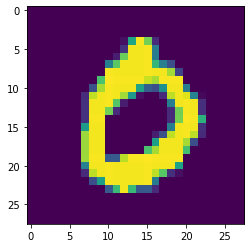

Prediction: 0


In [10]:
clean_preds = np.argmax(model.predict(x_test), axis=1)
clean_correct = np.sum(clean_preds == np.argmax(y_test, axis=1))
clean_total = y_test.shape[0]

clean_acc = clean_correct / clean_total
print("\nClean test set accuracy (model): %.2f%%" % (clean_acc * 100))

# Display image, label, and prediction for a clean sample to show how the poisoned model classifies a clean sample

c = 0 # class to display
i = 0 # image of the class to display

c_idx = np.where(np.argmax(y_test, 1) == c)[0][i] # index of the image in clean arrays

plt.imshow(x_test[c_idx].squeeze())
plt.show()
clean_label = c
print("Prediction: " + str(clean_preds[c_idx]))


Clean test set accuracy (DPA model_10): 94.14%


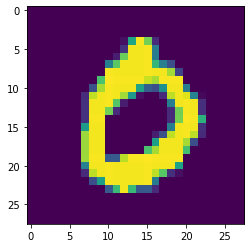

Prediction: 0


In [11]:
clean_preds = np.argmax(dpa_model_10.predict(x_test), axis=1)
clean_correct = np.sum(clean_preds == np.argmax(y_test, axis=1))
clean_total = y_test.shape[0]

clean_acc = clean_correct / clean_total
print("\nClean test set accuracy (DPA model_10): %.2f%%" % (clean_acc * 100))

# Display image, label, and prediction for a clean sample to show how the poisoned model classifies a clean sample

c = 0 # class to display
i = 0 # image of the class to display

c_idx = np.where(np.argmax(y_test, 1) == c)[0][i] # index of the image in clean arrays

plt.imshow(x_test[c_idx].squeeze())
plt.show()
clean_label = c
print("Prediction: " + str(clean_preds[c_idx]))


Clean test set accuracy (DPA model_20): 91.32%


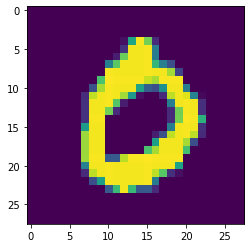

Prediction: 0


In [12]:
clean_preds = np.argmax(dpa_model_20.predict(x_test), axis=1)
clean_correct = np.sum(clean_preds == np.argmax(y_test, axis=1))
clean_total = y_test.shape[0]

clean_acc = clean_correct / clean_total
print("\nClean test set accuracy (DPA model_20): %.2f%%" % (clean_acc * 100))

# Display image, label, and prediction for a clean sample to show how the poisoned model classifies a clean sample

c = 0 # class to display
i = 0 # image of the class to display

c_idx = np.where(np.argmax(y_test, 1) == c)[0][i] # index of the image in clean arrays

plt.imshow(x_test[c_idx].squeeze())
plt.show()
clean_label = c
print("Prediction: " + str(clean_preds[c_idx]))


Clean test set accuracy (DPA model_30): 89.99%


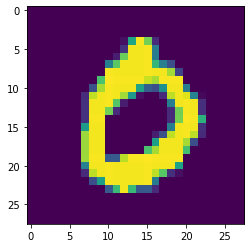

Prediction: 0


In [13]:
clean_preds = np.argmax(dpa_model_30.predict(x_test), axis=1)
clean_correct = np.sum(clean_preds == np.argmax(y_test, axis=1))
clean_total = y_test.shape[0]

clean_acc = clean_correct / clean_total
print("\nClean test set accuracy (DPA model_30): %.2f%%" % (clean_acc * 100))

# Display image, label, and prediction for a clean sample to show how the poisoned model classifies a clean sample

c = 0 # class to display
i = 0 # image of the class to display

c_idx = np.where(np.argmax(y_test, 1) == c)[0][i] # index of the image in clean arrays

plt.imshow(x_test[c_idx].squeeze())
plt.show()
clean_label = c
print("Prediction: " + str(clean_preds[c_idx]))

# Evaluate the performance of the trained models on poisoned data
When the trigger is added, we see a shift in performance. The single model performs the worst as no defense is in place to mitigate the effect of the poisoned. The DPA models show some robustnesss to the poison as they partition the training data, which spreads the effect of the poison between models in the ensemble.


Poison test set accuracy (model): 0.19%


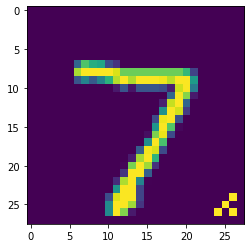

Prediction: 9


In [14]:
not_target = np.logical_not(np.all(y_test == targets, axis=1))
px_test, py_test = backdoor.poison(x_test[not_target], y_test[not_target])

poison_preds = np.argmax(model.predict(px_test), axis=1)
clean_correct = np.sum(poison_preds == np.argmax(y_test[not_target], axis=1))
clean_total = y_test.shape[0]

clean_acc = clean_correct / clean_total
print("\nPoison test set accuracy (model): %.2f%%" % (clean_acc * 100))

c = 0 # index to display
plt.imshow(px_test[c].squeeze())
plt.show()
clean_label = c
print("Prediction: " + str(poison_preds[c]))


Poison test set accuracy (DPA model_10): 62.08%


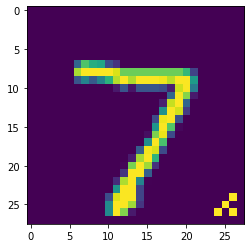

Prediction: 7


In [15]:
poison_preds = np.argmax(dpa_model_10.predict(px_test), axis=1)
clean_correct = np.sum(poison_preds == np.argmax(y_test[not_target], axis=1))
clean_total = y_test.shape[0]

clean_acc = clean_correct / clean_total
print("\nPoison test set accuracy (DPA model_10): %.2f%%" % (clean_acc * 100))

c = 0 # index to display
plt.imshow(px_test[c].squeeze())
plt.show()
clean_label = c
print("Prediction: " + str(poison_preds[c]))


Poison test set accuracy (DPA model_20): 71.60%


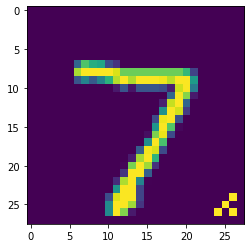

Prediction: 7


In [16]:
poison_preds = np.argmax(dpa_model_20.predict(px_test), axis=1)
clean_correct = np.sum(poison_preds == np.argmax(y_test[not_target], axis=1))
clean_total = y_test.shape[0]

clean_acc = clean_correct / clean_total
print("\nPoison test set accuracy (DPA model_20): %.2f%%" % (clean_acc * 100))

c = 0 # index to display
plt.imshow(px_test[c].squeeze())
plt.show()
clean_label = c
print("Prediction: " + str(poison_preds[c]))


Poison test set accuracy (DPA model_30): 72.76%


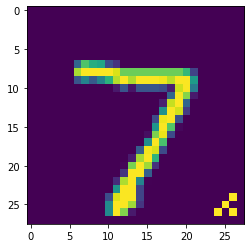

Prediction: 7


In [17]:
poison_preds = np.argmax(dpa_model_30.predict(px_test), axis=1)
clean_correct = np.sum(poison_preds == np.argmax(y_test[not_target], axis=1))
clean_total = y_test.shape[0]

clean_acc = clean_correct / clean_total
print("\nPoison test set accuracy (DPA model_30): %.2f%%" % (clean_acc * 100))

c = 0 # index to display
plt.imshow(px_test[c].squeeze())
plt.show()
clean_label = c
print("Prediction: " + str(poison_preds[c]))